In [1]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

# Add project root to sys.path
import sys
import os
sys.path.append(os.path.abspath('..'))

# Import from base_script.py (which is in the root folder)
from base_script import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sub_cond_path = '../subject_info.xlsx'
base_nifti_folder = '../data_FC'
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [3]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

# Encode condition just for sampling
condition_list = np.array([condition_map[t] for t in all_tms_type])  # e.g., 'C' → 0, etc.

# Create combo keys for subject × TMS condition
combo_keys = np.array([f"{s}_{c}" for s, c in zip(all_subject_id, condition_list)])
combo_counts = Counter(combo_keys)

# Compute inverse weights for sampling
weights = np.array([1.0 / combo_counts[k] for k in combo_keys])
weights_tensor = torch.DoubleTensor(weights)

[WARN] File not found: ../data_FC/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: ../data_FC/NODEAP_88/D0/conn_matrix_w_sphere.mat


In [4]:
# Convert to torch tensors
X_tensor = preprocess_for_torch(all_corr_data)  
subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)

sampler = WeightedRandomSampler(weights_tensor, num_samples=len(weights_tensor), replacement=True)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [5]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
hidden_dim = 64 # 128 (64 for FC vector)  
NUM_EPOCH = 500
from sklearn.preprocessing import LabelEncoder
LR = 3e-4
le = LabelEncoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=device, epochs=NUM_EPOCH, label_encoder=le, log_batch_info=True)


===== Epoch 1 =====


Epoch 1/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 199.34it/s]


Epoch 1, Loss: 104.8471, Recon: 104.6066, KL: 0.2405

===== Epoch 2 =====


Epoch 2/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 685.94it/s]


Epoch 2, Loss: 101.7510, Recon: 101.5159, KL: 0.2352

===== Epoch 3 =====


Epoch 3/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 999.81it/s]


Epoch 3, Loss: 108.3308, Recon: 108.0206, KL: 0.3101

===== Epoch 4 =====


Epoch 4/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1112.57it/s]


Epoch 4, Loss: 103.6539, Recon: 103.2842, KL: 0.3697

===== Epoch 5 =====


Epoch 5/500: 100%|█████████████████████████████| 11/11 [00:00<00:00, 914.77it/s]


Epoch 5, Loss: 104.8957, Recon: 104.2603, KL: 0.6354

===== Epoch 6 =====


Epoch 6/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1129.79it/s]


Epoch 6, Loss: 96.2695, Recon: 95.4819, KL: 0.7876

===== Epoch 7 =====


Epoch 7/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1214.94it/s]


Epoch 7, Loss: 99.1912, Recon: 97.9252, KL: 1.2660

===== Epoch 8 =====


Epoch 8/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1215.07it/s]


Epoch 8, Loss: 98.4400, Recon: 96.3374, KL: 2.1026

===== Epoch 9 =====


Epoch 9/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 1091.05it/s]


Epoch 9, Loss: 98.6679, Recon: 95.3663, KL: 3.3017

===== Epoch 10 =====


Epoch 10/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1155.98it/s]


Epoch 10, Loss: 93.3116, Recon: 88.2151, KL: 5.0965

===== Epoch 11 =====


Epoch 11/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1196.57it/s]


Epoch 11, Loss: 90.1624, Recon: 84.1899, KL: 5.9725

===== Epoch 12 =====


Epoch 12/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1047.20it/s]


Epoch 12, Loss: 85.2775, Recon: 78.9374, KL: 6.3401

===== Epoch 13 =====


Epoch 13/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1098.01it/s]


Epoch 13, Loss: 85.5735, Recon: 79.8776, KL: 5.6959

===== Epoch 14 =====


Epoch 14/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1215.71it/s]


Epoch 14, Loss: 80.8675, Recon: 75.2525, KL: 5.6150

===== Epoch 15 =====


Epoch 15/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1212.96it/s]


Epoch 15, Loss: 81.3469, Recon: 75.9139, KL: 5.4331

===== Epoch 16 =====


Epoch 16/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1230.99it/s]


Epoch 16, Loss: 76.8718, Recon: 71.2295, KL: 5.6423

===== Epoch 17 =====


Epoch 17/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1164.64it/s]


Epoch 17, Loss: 78.2206, Recon: 71.8054, KL: 6.4152

===== Epoch 18 =====


Epoch 18/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 828.38it/s]


Epoch 18, Loss: 80.0742, Recon: 73.6533, KL: 6.4209

===== Epoch 19 =====


Epoch 19/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1125.11it/s]


Epoch 19, Loss: 73.5006, Recon: 67.1390, KL: 6.3616

===== Epoch 20 =====


Epoch 20/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 992.33it/s]


Epoch 20, Loss: 70.2877, Recon: 64.2661, KL: 6.0216

===== Epoch 21 =====


Epoch 21/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1071.27it/s]


Epoch 21, Loss: 68.9436, Recon: 62.0986, KL: 6.8450

===== Epoch 22 =====


Epoch 22/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1173.68it/s]


Epoch 22, Loss: 67.4953, Recon: 59.7106, KL: 7.7848

===== Epoch 23 =====


Epoch 23/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1002.01it/s]


Epoch 23, Loss: 68.3566, Recon: 60.2769, KL: 8.0796

===== Epoch 24 =====


Epoch 24/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1138.97it/s]


Epoch 24, Loss: 65.2800, Recon: 57.5693, KL: 7.7107

===== Epoch 25 =====


Epoch 25/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1215.48it/s]


Epoch 25, Loss: 64.9406, Recon: 56.0083, KL: 8.9323

===== Epoch 26 =====


Epoch 26/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1158.73it/s]


Epoch 26, Loss: 65.8865, Recon: 57.1266, KL: 8.7599

===== Epoch 27 =====


Epoch 27/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1217.09it/s]


Epoch 27, Loss: 60.7267, Recon: 52.0551, KL: 8.6716

===== Epoch 28 =====


Epoch 28/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1029.19it/s]


Epoch 28, Loss: 60.3957, Recon: 51.7182, KL: 8.6775

===== Epoch 29 =====


Epoch 29/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 841.48it/s]


Epoch 29, Loss: 59.6288, Recon: 50.7356, KL: 8.8932

===== Epoch 30 =====


Epoch 30/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1230.00it/s]


Epoch 30, Loss: 61.8362, Recon: 52.6680, KL: 9.1682

===== Epoch 31 =====


Epoch 31/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1178.09it/s]


Epoch 31, Loss: 58.2026, Recon: 49.5404, KL: 8.6621

===== Epoch 32 =====


Epoch 32/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1308.16it/s]


Epoch 32, Loss: 54.6595, Recon: 45.6348, KL: 9.0247

===== Epoch 33 =====


Epoch 33/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1203.59it/s]


Epoch 33, Loss: 59.2274, Recon: 50.6880, KL: 8.5394

===== Epoch 34 =====


Epoch 34/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1177.99it/s]


Epoch 34, Loss: 57.2424, Recon: 48.3908, KL: 8.8516

===== Epoch 35 =====


Epoch 35/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 991.43it/s]


Epoch 35, Loss: 57.9531, Recon: 48.9544, KL: 8.9987

===== Epoch 36 =====


Epoch 36/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1227.12it/s]


Epoch 36, Loss: 56.9237, Recon: 48.5088, KL: 8.4149

===== Epoch 37 =====


Epoch 37/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1196.57it/s]


Epoch 37, Loss: 57.5439, Recon: 48.8839, KL: 8.6600

===== Epoch 38 =====


Epoch 38/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1097.02it/s]


Epoch 38, Loss: 56.8974, Recon: 47.8657, KL: 9.0316

===== Epoch 39 =====


Epoch 39/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1217.50it/s]


Epoch 39, Loss: 55.3210, Recon: 46.9472, KL: 8.3738

===== Epoch 40 =====


Epoch 40/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1197.47it/s]


Epoch 40, Loss: 58.3819, Recon: 49.9899, KL: 8.3920

===== Epoch 41 =====


Epoch 41/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1284.48it/s]


Epoch 41, Loss: 55.4759, Recon: 47.3374, KL: 8.1386

===== Epoch 42 =====


Epoch 42/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1248.58it/s]


Epoch 42, Loss: 54.8674, Recon: 47.1052, KL: 7.7622

===== Epoch 43 =====


Epoch 43/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1295.63it/s]


Epoch 43, Loss: 54.0302, Recon: 45.8882, KL: 8.1420

===== Epoch 44 =====


Epoch 44/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1309.68it/s]


Epoch 44, Loss: 57.4661, Recon: 49.2017, KL: 8.2644

===== Epoch 45 =====


Epoch 45/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1314.34it/s]


Epoch 45, Loss: 54.7073, Recon: 46.9113, KL: 7.7959

===== Epoch 46 =====


Epoch 46/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1019.65it/s]


Epoch 46, Loss: 54.8230, Recon: 46.7650, KL: 8.0579

===== Epoch 47 =====


Epoch 47/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1290.92it/s]


Epoch 47, Loss: 54.2856, Recon: 46.4750, KL: 7.8106

===== Epoch 48 =====


Epoch 48/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1298.22it/s]


Epoch 48, Loss: 52.3371, Recon: 44.5658, KL: 7.7713

===== Epoch 49 =====


Epoch 49/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1298.84it/s]


Epoch 49, Loss: 55.1337, Recon: 47.1259, KL: 8.0077

===== Epoch 50 =====


Epoch 50/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1245.17it/s]


Epoch 50, Loss: 50.8242, Recon: 42.8244, KL: 7.9997

===== Epoch 51 =====


Epoch 51/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1323.09it/s]


Epoch 51, Loss: 53.0164, Recon: 45.0968, KL: 7.9195

===== Epoch 52 =====


Epoch 52/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1315.62it/s]


Epoch 52, Loss: 51.5457, Recon: 43.7466, KL: 7.7991

===== Epoch 53 =====


Epoch 53/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1282.80it/s]


Epoch 53, Loss: 52.0724, Recon: 44.2337, KL: 7.8387

===== Epoch 54 =====


Epoch 54/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1294.14it/s]


Epoch 54, Loss: 51.3885, Recon: 43.1449, KL: 8.2436

===== Epoch 55 =====


Epoch 55/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1288.79it/s]


Epoch 55, Loss: 51.1926, Recon: 43.1863, KL: 8.0064

===== Epoch 56 =====


Epoch 56/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1295.96it/s]


Epoch 56, Loss: 52.7716, Recon: 44.6708, KL: 8.1008

===== Epoch 57 =====


Epoch 57/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1318.13it/s]


Epoch 57, Loss: 55.8455, Recon: 46.8299, KL: 9.0156

===== Epoch 58 =====


Epoch 58/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1310.72it/s]


Epoch 58, Loss: 53.3951, Recon: 45.4063, KL: 7.9888

===== Epoch 59 =====


Epoch 59/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1082.43it/s]


Epoch 59, Loss: 54.6545, Recon: 45.5560, KL: 9.0985

===== Epoch 60 =====


Epoch 60/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1281.45it/s]


Epoch 60, Loss: 51.6500, Recon: 43.5134, KL: 8.1367

===== Epoch 61 =====


Epoch 61/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1064.52it/s]


Epoch 61, Loss: 50.7855, Recon: 42.7897, KL: 7.9958

===== Epoch 62 =====


Epoch 62/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1039.81it/s]


Epoch 62, Loss: 50.0646, Recon: 42.0564, KL: 8.0082

===== Epoch 63 =====


Epoch 63/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1300.56it/s]


Epoch 63, Loss: 50.8208, Recon: 42.4933, KL: 8.3274

===== Epoch 64 =====


Epoch 64/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1316.29it/s]


Epoch 64, Loss: 50.7968, Recon: 42.2752, KL: 8.5216

===== Epoch 65 =====


Epoch 65/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1314.57it/s]


Epoch 65, Loss: 52.0286, Recon: 43.5856, KL: 8.4430

===== Epoch 66 =====


Epoch 66/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1180.13it/s]


Epoch 66, Loss: 49.2101, Recon: 41.0642, KL: 8.1458

===== Epoch 67 =====


Epoch 67/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1136.36it/s]


Epoch 67, Loss: 49.8530, Recon: 41.4773, KL: 8.3758

===== Epoch 68 =====


Epoch 68/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1246.15it/s]


Epoch 68, Loss: 51.8191, Recon: 42.7233, KL: 9.0958

===== Epoch 69 =====


Epoch 69/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1273.46it/s]


Epoch 69, Loss: 51.9570, Recon: 42.9302, KL: 9.0268

===== Epoch 70 =====


Epoch 70/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1288.50it/s]


Epoch 70, Loss: 51.1035, Recon: 42.1970, KL: 8.9065

===== Epoch 71 =====


Epoch 71/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1150.76it/s]


Epoch 71, Loss: 49.7399, Recon: 41.0338, KL: 8.7061

===== Epoch 72 =====


Epoch 72/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1262.07it/s]


Epoch 72, Loss: 46.9196, Recon: 38.5063, KL: 8.4133

===== Epoch 73 =====


Epoch 73/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1287.13it/s]


Epoch 73, Loss: 48.5598, Recon: 39.1385, KL: 9.4213

===== Epoch 74 =====


Epoch 74/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1171.92it/s]


Epoch 74, Loss: 46.6675, Recon: 38.0759, KL: 8.5916

===== Epoch 75 =====


Epoch 75/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1181.40it/s]


Epoch 75, Loss: 48.4720, Recon: 39.6270, KL: 8.8450

===== Epoch 76 =====


Epoch 76/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1316.59it/s]


Epoch 76, Loss: 47.7885, Recon: 38.8085, KL: 8.9800

===== Epoch 77 =====


Epoch 77/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1313.93it/s]


Epoch 77, Loss: 47.3943, Recon: 38.5914, KL: 8.8029

===== Epoch 78 =====


Epoch 78/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1279.39it/s]


Epoch 78, Loss: 46.4541, Recon: 37.5735, KL: 8.8805

===== Epoch 79 =====


Epoch 79/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1310.05it/s]


Epoch 79, Loss: 46.7201, Recon: 37.9065, KL: 8.8136

===== Epoch 80 =====


Epoch 80/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1247.02it/s]


Epoch 80, Loss: 46.3958, Recon: 37.3475, KL: 9.0484

===== Epoch 81 =====


Epoch 81/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1171.71it/s]


Epoch 81, Loss: 46.7776, Recon: 37.3245, KL: 9.4531

===== Epoch 82 =====


Epoch 82/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1119.70it/s]


Epoch 82, Loss: 46.4802, Recon: 37.6489, KL: 8.8312

===== Epoch 83 =====


Epoch 83/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1273.70it/s]


Epoch 83, Loss: 46.6232, Recon: 37.1614, KL: 9.4617

===== Epoch 84 =====


Epoch 84/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 952.88it/s]


Epoch 84, Loss: 45.3983, Recon: 35.8370, KL: 9.5613

===== Epoch 85 =====


Epoch 85/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1056.35it/s]


Epoch 85, Loss: 44.8593, Recon: 36.1499, KL: 8.7094

===== Epoch 86 =====


Epoch 86/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1217.12it/s]


Epoch 86, Loss: 45.0275, Recon: 36.0088, KL: 9.0187

===== Epoch 87 =====


Epoch 87/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1138.74it/s]


Epoch 87, Loss: 45.8693, Recon: 36.0215, KL: 9.8478

===== Epoch 88 =====


Epoch 88/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1256.74it/s]


Epoch 88, Loss: 45.5661, Recon: 35.7770, KL: 9.7891

===== Epoch 89 =====


Epoch 89/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1258.59it/s]


Epoch 89, Loss: 44.2985, Recon: 34.9775, KL: 9.3210

===== Epoch 90 =====


Epoch 90/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1051.73it/s]


Epoch 90, Loss: 44.8414, Recon: 35.5334, KL: 9.3080

===== Epoch 91 =====


Epoch 91/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1159.14it/s]


Epoch 91, Loss: 43.6038, Recon: 34.2985, KL: 9.3053

===== Epoch 92 =====


Epoch 92/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1261.44it/s]


Epoch 92, Loss: 44.0336, Recon: 34.8945, KL: 9.1391

===== Epoch 93 =====


Epoch 93/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1231.64it/s]


Epoch 93, Loss: 44.7098, Recon: 35.0208, KL: 9.6890

===== Epoch 94 =====


Epoch 94/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 868.14it/s]


Epoch 94, Loss: 43.4447, Recon: 33.5243, KL: 9.9204

===== Epoch 95 =====


Epoch 95/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1250.71it/s]


Epoch 95, Loss: 43.4440, Recon: 34.5690, KL: 8.8750

===== Epoch 96 =====


Epoch 96/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1077.60it/s]


Epoch 96, Loss: 45.2302, Recon: 35.9024, KL: 9.3278

===== Epoch 97 =====


Epoch 97/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1259.00it/s]


Epoch 97, Loss: 45.1097, Recon: 35.5237, KL: 9.5860

===== Epoch 98 =====


Epoch 98/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 1275.68it/s]


Epoch 98, Loss: 44.1567, Recon: 34.7488, KL: 9.4079

===== Epoch 99 =====


Epoch 99/500: 100%|████████████████████████████| 11/11 [00:00<00:00, 819.90it/s]


Epoch 99, Loss: 44.0108, Recon: 34.6939, KL: 9.3168

===== Epoch 100 =====


Epoch 100/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 909.67it/s]


Epoch 100, Loss: 43.3329, Recon: 33.7960, KL: 9.5369

===== Epoch 101 =====


Epoch 101/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1200.21it/s]


Epoch 101, Loss: 42.5912, Recon: 33.4510, KL: 9.1402

===== Epoch 102 =====


Epoch 102/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.35it/s]


Epoch 102, Loss: 43.8273, Recon: 34.3884, KL: 9.4389

===== Epoch 103 =====


Epoch 103/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1068.76it/s]


Epoch 103, Loss: 43.5358, Recon: 34.0393, KL: 9.4965

===== Epoch 104 =====


Epoch 104/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1131.09it/s]


Epoch 104, Loss: 42.8437, Recon: 33.2278, KL: 9.6158

===== Epoch 105 =====


Epoch 105/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1237.52it/s]


Epoch 105, Loss: 41.4835, Recon: 32.2077, KL: 9.2758

===== Epoch 106 =====


Epoch 106/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 953.29it/s]


Epoch 106, Loss: 41.9747, Recon: 32.6308, KL: 9.3439

===== Epoch 107 =====


Epoch 107/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1071.37it/s]


Epoch 107, Loss: 42.5375, Recon: 33.0127, KL: 9.5248

===== Epoch 108 =====


Epoch 108/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.47it/s]


Epoch 108, Loss: 43.3993, Recon: 33.5312, KL: 9.8681

===== Epoch 109 =====


Epoch 109/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.46it/s]


Epoch 109, Loss: 40.4894, Recon: 31.2342, KL: 9.2552

===== Epoch 110 =====


Epoch 110/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.34it/s]


Epoch 110, Loss: 42.2359, Recon: 32.5274, KL: 9.7085

===== Epoch 111 =====


Epoch 111/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1059.44it/s]


Epoch 111, Loss: 40.9652, Recon: 31.2918, KL: 9.6733

===== Epoch 112 =====


Epoch 112/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1056.48it/s]


Epoch 112, Loss: 43.0369, Recon: 33.4199, KL: 9.6171

===== Epoch 113 =====


Epoch 113/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.40it/s]


Epoch 113, Loss: 41.1222, Recon: 31.5670, KL: 9.5552

===== Epoch 114 =====


Epoch 114/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.92it/s]


Epoch 114, Loss: 42.0767, Recon: 31.8263, KL: 10.2504

===== Epoch 115 =====


Epoch 115/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.16it/s]


Epoch 115, Loss: 40.3886, Recon: 31.0683, KL: 9.3203

===== Epoch 116 =====


Epoch 116/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1192.15it/s]


Epoch 116, Loss: 41.3880, Recon: 31.7117, KL: 9.6763

===== Epoch 117 =====


Epoch 117/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1255.44it/s]


Epoch 117, Loss: 39.7390, Recon: 30.4747, KL: 9.2643

===== Epoch 118 =====


Epoch 118/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.84it/s]


Epoch 118, Loss: 41.4061, Recon: 31.8063, KL: 9.5997

===== Epoch 119 =====


Epoch 119/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1103.08it/s]


Epoch 119, Loss: 41.5925, Recon: 32.2791, KL: 9.3134

===== Epoch 120 =====


Epoch 120/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1158.85it/s]


Epoch 120, Loss: 40.2710, Recon: 30.6924, KL: 9.5786

===== Epoch 121 =====


Epoch 121/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.46it/s]


Epoch 121, Loss: 41.1905, Recon: 31.5401, KL: 9.6504

===== Epoch 122 =====


Epoch 122/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1260.62it/s]


Epoch 122, Loss: 39.8718, Recon: 30.2501, KL: 9.6217

===== Epoch 123 =====


Epoch 123/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 765.85it/s]


Epoch 123, Loss: 40.6191, Recon: 30.7380, KL: 9.8811

===== Epoch 124 =====


Epoch 124/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1163.53it/s]


Epoch 124, Loss: 41.6201, Recon: 31.7315, KL: 9.8886

===== Epoch 125 =====


Epoch 125/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.17it/s]


Epoch 125, Loss: 41.0959, Recon: 31.6528, KL: 9.4431

===== Epoch 126 =====


Epoch 126/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 846.09it/s]


Epoch 126, Loss: 40.1425, Recon: 30.7887, KL: 9.3537

===== Epoch 127 =====


Epoch 127/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1061.56it/s]


Epoch 127, Loss: 39.1424, Recon: 29.3591, KL: 9.7834

===== Epoch 128 =====


Epoch 128/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.43it/s]


Epoch 128, Loss: 40.4810, Recon: 30.8193, KL: 9.6617

===== Epoch 129 =====


Epoch 129/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1194.62it/s]


Epoch 129, Loss: 41.0465, Recon: 31.3750, KL: 9.6715

===== Epoch 130 =====


Epoch 130/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.16it/s]


Epoch 130, Loss: 40.0740, Recon: 30.6302, KL: 9.4438

===== Epoch 131 =====


Epoch 131/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 997.13it/s]


Epoch 131, Loss: 38.5985, Recon: 29.5135, KL: 9.0851

===== Epoch 132 =====


Epoch 132/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.23it/s]


Epoch 132, Loss: 39.9166, Recon: 29.6710, KL: 10.2456

===== Epoch 133 =====


Epoch 133/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.79it/s]


Epoch 133, Loss: 39.0738, Recon: 29.1888, KL: 9.8851

===== Epoch 134 =====


Epoch 134/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.44it/s]


Epoch 134, Loss: 39.2740, Recon: 29.1240, KL: 10.1499

===== Epoch 135 =====


Epoch 135/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1121.17it/s]


Epoch 135, Loss: 39.0036, Recon: 29.4980, KL: 9.5056

===== Epoch 136 =====


Epoch 136/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1278.64it/s]


Epoch 136, Loss: 39.9096, Recon: 30.0503, KL: 9.8593

===== Epoch 137 =====


Epoch 137/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1238.99it/s]


Epoch 137, Loss: 40.5046, Recon: 30.4687, KL: 10.0359

===== Epoch 138 =====


Epoch 138/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.68it/s]


Epoch 138, Loss: 38.8265, Recon: 29.0589, KL: 9.7676

===== Epoch 139 =====


Epoch 139/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.90it/s]


Epoch 139, Loss: 38.2948, Recon: 28.8574, KL: 9.4375

===== Epoch 140 =====


Epoch 140/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1186.75it/s]


Epoch 140, Loss: 38.4906, Recon: 28.9686, KL: 9.5220

===== Epoch 141 =====


Epoch 141/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.03it/s]


Epoch 141, Loss: 39.6116, Recon: 29.7072, KL: 9.9045

===== Epoch 142 =====


Epoch 142/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1026.12it/s]


Epoch 142, Loss: 38.9468, Recon: 29.0808, KL: 9.8660

===== Epoch 143 =====


Epoch 143/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1130.04it/s]


Epoch 143, Loss: 38.3088, Recon: 29.0207, KL: 9.2881

===== Epoch 144 =====


Epoch 144/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.88it/s]


Epoch 144, Loss: 39.1560, Recon: 29.1352, KL: 10.0208

===== Epoch 145 =====


Epoch 145/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.15it/s]


Epoch 145, Loss: 39.6431, Recon: 29.7086, KL: 9.9345

===== Epoch 146 =====


Epoch 146/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.38it/s]


Epoch 146, Loss: 39.7814, Recon: 29.6622, KL: 10.1192

===== Epoch 147 =====


Epoch 147/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1170.35it/s]


Epoch 147, Loss: 37.8713, Recon: 28.3768, KL: 9.4944

===== Epoch 148 =====


Epoch 148/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.40it/s]


Epoch 148, Loss: 37.5399, Recon: 27.7954, KL: 9.7445

===== Epoch 149 =====


Epoch 149/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.14it/s]


Epoch 149, Loss: 37.3575, Recon: 27.5997, KL: 9.7578

===== Epoch 150 =====


Epoch 150/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.27it/s]


Epoch 150, Loss: 38.3521, Recon: 28.4897, KL: 9.8624

===== Epoch 151 =====


Epoch 151/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.90it/s]


Epoch 151, Loss: 38.1554, Recon: 28.2135, KL: 9.9419

===== Epoch 152 =====


Epoch 152/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1176.34it/s]


Epoch 152, Loss: 38.5966, Recon: 28.8562, KL: 9.7403

===== Epoch 153 =====


Epoch 153/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1195.52it/s]


Epoch 153, Loss: 38.4432, Recon: 28.6880, KL: 9.7552

===== Epoch 154 =====


Epoch 154/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1087.30it/s]


Epoch 154, Loss: 37.6355, Recon: 27.8218, KL: 9.8137

===== Epoch 155 =====


Epoch 155/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1072.44it/s]


Epoch 155, Loss: 38.3517, Recon: 28.3520, KL: 9.9997

===== Epoch 156 =====


Epoch 156/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1164.67it/s]


Epoch 156, Loss: 39.2450, Recon: 28.9829, KL: 10.2621

===== Epoch 157 =====


Epoch 157/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.74it/s]


Epoch 157, Loss: 37.4104, Recon: 27.7526, KL: 9.6577

===== Epoch 158 =====


Epoch 158/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 255.42it/s]


Epoch 158, Loss: 37.9549, Recon: 28.2719, KL: 9.6830

===== Epoch 159 =====


Epoch 159/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1200.21it/s]


Epoch 159, Loss: 38.6571, Recon: 28.6251, KL: 10.0321

===== Epoch 160 =====


Epoch 160/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1209.46it/s]


Epoch 160, Loss: 37.9879, Recon: 27.6979, KL: 10.2900

===== Epoch 161 =====


Epoch 161/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.30it/s]


Epoch 161, Loss: 37.5904, Recon: 27.7318, KL: 9.8586

===== Epoch 162 =====


Epoch 162/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1041.87it/s]


Epoch 162, Loss: 37.8689, Recon: 27.8589, KL: 10.0100

===== Epoch 163 =====


Epoch 163/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.90it/s]


Epoch 163, Loss: 36.6424, Recon: 26.5208, KL: 10.1216

===== Epoch 164 =====


Epoch 164/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.42it/s]


Epoch 164, Loss: 37.8678, Recon: 27.6525, KL: 10.2153

===== Epoch 165 =====


Epoch 165/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1047.12it/s]


Epoch 165, Loss: 37.4345, Recon: 27.5235, KL: 9.9111

===== Epoch 166 =====


Epoch 166/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.79it/s]


Epoch 166, Loss: 37.1825, Recon: 27.3684, KL: 9.8141

===== Epoch 167 =====


Epoch 167/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.42it/s]


Epoch 167, Loss: 36.1106, Recon: 26.4864, KL: 9.6242

===== Epoch 168 =====


Epoch 168/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 856.63it/s]


Epoch 168, Loss: 37.2564, Recon: 27.2567, KL: 9.9997

===== Epoch 169 =====


Epoch 169/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.85it/s]


Epoch 169, Loss: 36.1079, Recon: 26.6616, KL: 9.4464

===== Epoch 170 =====


Epoch 170/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.32it/s]


Epoch 170, Loss: 37.4897, Recon: 27.5697, KL: 9.9199

===== Epoch 171 =====


Epoch 171/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1317.87it/s]


Epoch 171, Loss: 37.3324, Recon: 27.2985, KL: 10.0339

===== Epoch 172 =====


Epoch 172/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.92it/s]


Epoch 172, Loss: 36.6142, Recon: 26.4853, KL: 10.1290

===== Epoch 173 =====


Epoch 173/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.72it/s]


Epoch 173, Loss: 35.8550, Recon: 26.2314, KL: 9.6236

===== Epoch 174 =====


Epoch 174/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1249.59it/s]


Epoch 174, Loss: 35.8285, Recon: 26.2439, KL: 9.5846

===== Epoch 175 =====


Epoch 175/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.77it/s]


Epoch 175, Loss: 35.7268, Recon: 26.0769, KL: 9.6499

===== Epoch 176 =====


Epoch 176/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.34it/s]


Epoch 176, Loss: 36.7773, Recon: 27.2563, KL: 9.5210

===== Epoch 177 =====


Epoch 177/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.01it/s]


Epoch 177, Loss: 35.5145, Recon: 26.0483, KL: 9.4662

===== Epoch 178 =====


Epoch 178/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.61it/s]


Epoch 178, Loss: 35.9857, Recon: 26.4474, KL: 9.5383

===== Epoch 179 =====


Epoch 179/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.43it/s]


Epoch 179, Loss: 36.6414, Recon: 26.6511, KL: 9.9903

===== Epoch 180 =====


Epoch 180/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.70it/s]


Epoch 180, Loss: 36.1456, Recon: 26.4394, KL: 9.7062

===== Epoch 181 =====


Epoch 181/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1083.42it/s]


Epoch 181, Loss: 35.8534, Recon: 26.1013, KL: 9.7521

===== Epoch 182 =====


Epoch 182/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1174.19it/s]


Epoch 182, Loss: 36.8261, Recon: 26.8296, KL: 9.9965

===== Epoch 183 =====


Epoch 183/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1268.55it/s]


Epoch 183, Loss: 37.2926, Recon: 27.5545, KL: 9.7381

===== Epoch 184 =====


Epoch 184/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1262.79it/s]


Epoch 184, Loss: 34.9390, Recon: 25.3319, KL: 9.6071

===== Epoch 185 =====


Epoch 185/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.62it/s]


Epoch 185, Loss: 34.9306, Recon: 25.3520, KL: 9.5786

===== Epoch 186 =====


Epoch 186/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.10it/s]


Epoch 186, Loss: 36.0587, Recon: 26.0986, KL: 9.9601

===== Epoch 187 =====


Epoch 187/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.06it/s]


Epoch 187, Loss: 34.5737, Recon: 24.9365, KL: 9.6373

===== Epoch 188 =====


Epoch 188/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.94it/s]


Epoch 188, Loss: 35.5778, Recon: 25.9459, KL: 9.6319

===== Epoch 189 =====


Epoch 189/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.64it/s]


Epoch 189, Loss: 36.0111, Recon: 26.2750, KL: 9.7360

===== Epoch 190 =====


Epoch 190/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.51it/s]


Epoch 190, Loss: 34.8586, Recon: 25.3683, KL: 9.4903

===== Epoch 191 =====


Epoch 191/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1052.52it/s]


Epoch 191, Loss: 35.7085, Recon: 26.1560, KL: 9.5525

===== Epoch 192 =====


Epoch 192/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1188.43it/s]


Epoch 192, Loss: 36.0248, Recon: 26.2251, KL: 9.7997

===== Epoch 193 =====


Epoch 193/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.24it/s]


Epoch 193, Loss: 36.2324, Recon: 26.4050, KL: 9.8274

===== Epoch 194 =====


Epoch 194/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.78it/s]


Epoch 194, Loss: 36.3708, Recon: 26.3123, KL: 10.0585

===== Epoch 195 =====


Epoch 195/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.16it/s]


Epoch 195, Loss: 34.9980, Recon: 25.1039, KL: 9.8941

===== Epoch 196 =====


Epoch 196/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.16it/s]


Epoch 196, Loss: 33.9849, Recon: 24.4922, KL: 9.4927

===== Epoch 197 =====


Epoch 197/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1145.59it/s]


Epoch 197, Loss: 35.0401, Recon: 25.2726, KL: 9.7675

===== Epoch 198 =====


Epoch 198/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.64it/s]


Epoch 198, Loss: 35.0306, Recon: 24.8958, KL: 10.1348

===== Epoch 199 =====


Epoch 199/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.25it/s]


Epoch 199, Loss: 36.6478, Recon: 26.8907, KL: 9.7571

===== Epoch 200 =====


Epoch 200/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1263.69it/s]


Epoch 200, Loss: 34.9437, Recon: 24.8863, KL: 10.0574

===== Epoch 201 =====


Epoch 201/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.55it/s]


Epoch 201, Loss: 34.5112, Recon: 25.1963, KL: 9.3149

===== Epoch 202 =====


Epoch 202/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1214.94it/s]


Epoch 202, Loss: 35.3958, Recon: 25.3748, KL: 10.0209

===== Epoch 203 =====


Epoch 203/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1121.06it/s]


Epoch 203, Loss: 34.2619, Recon: 24.5402, KL: 9.7217

===== Epoch 204 =====


Epoch 204/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.42it/s]


Epoch 204, Loss: 34.3406, Recon: 24.7195, KL: 9.6212

===== Epoch 205 =====


Epoch 205/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.16it/s]


Epoch 205, Loss: 35.8932, Recon: 26.0167, KL: 9.8764

===== Epoch 206 =====


Epoch 206/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.08it/s]


Epoch 206, Loss: 35.4156, Recon: 25.2686, KL: 10.1470

===== Epoch 207 =====


Epoch 207/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1184.59it/s]


Epoch 207, Loss: 35.0063, Recon: 24.9565, KL: 10.0498

===== Epoch 208 =====


Epoch 208/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.95it/s]


Epoch 208, Loss: 34.1717, Recon: 24.5115, KL: 9.6602

===== Epoch 209 =====


Epoch 209/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.94it/s]


Epoch 209, Loss: 35.1698, Recon: 25.3600, KL: 9.8098

===== Epoch 210 =====


Epoch 210/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.21it/s]


Epoch 210, Loss: 33.1993, Recon: 23.6976, KL: 9.5017

===== Epoch 211 =====


Epoch 211/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.77it/s]


Epoch 211, Loss: 34.0729, Recon: 24.2242, KL: 9.8487

===== Epoch 212 =====


Epoch 212/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1317.98it/s]


Epoch 212, Loss: 34.0891, Recon: 24.3732, KL: 9.7159

===== Epoch 213 =====


Epoch 213/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.85it/s]


Epoch 213, Loss: 34.0208, Recon: 24.2718, KL: 9.7490

===== Epoch 214 =====


Epoch 214/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.56it/s]


Epoch 214, Loss: 34.2177, Recon: 24.5699, KL: 9.6478

===== Epoch 215 =====


Epoch 215/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.23it/s]


Epoch 215, Loss: 33.9685, Recon: 24.3169, KL: 9.6516

===== Epoch 216 =====


Epoch 216/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.24it/s]


Epoch 216, Loss: 34.3072, Recon: 24.5309, KL: 9.7763

===== Epoch 217 =====


Epoch 217/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.16it/s]


Epoch 217, Loss: 34.3131, Recon: 24.5816, KL: 9.7315

===== Epoch 218 =====


Epoch 218/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.44it/s]


Epoch 218, Loss: 34.8219, Recon: 24.8660, KL: 9.9559

===== Epoch 219 =====


Epoch 219/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1241.12it/s]


Epoch 219, Loss: 33.9837, Recon: 24.1975, KL: 9.7862

===== Epoch 220 =====


Epoch 220/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.44it/s]


Epoch 220, Loss: 34.5299, Recon: 24.6564, KL: 9.8735

===== Epoch 221 =====


Epoch 221/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 981.69it/s]


Epoch 221, Loss: 33.5848, Recon: 23.9105, KL: 9.6743

===== Epoch 222 =====


Epoch 222/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1193.20it/s]


Epoch 222, Loss: 33.8812, Recon: 24.2118, KL: 9.6694

===== Epoch 223 =====


Epoch 223/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1260.76it/s]


Epoch 223, Loss: 33.0479, Recon: 23.5821, KL: 9.4658

===== Epoch 224 =====


Epoch 224/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.32it/s]


Epoch 224, Loss: 33.3058, Recon: 23.7939, KL: 9.5120

===== Epoch 225 =====


Epoch 225/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.02it/s]


Epoch 225, Loss: 33.1790, Recon: 23.5152, KL: 9.6638

===== Epoch 226 =====


Epoch 226/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.68it/s]


Epoch 226, Loss: 33.2082, Recon: 23.5520, KL: 9.6561

===== Epoch 227 =====


Epoch 227/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.82it/s]


Epoch 227, Loss: 33.6203, Recon: 24.0767, KL: 9.5436

===== Epoch 228 =====


Epoch 228/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.75it/s]


Epoch 228, Loss: 33.2638, Recon: 23.5868, KL: 9.6769

===== Epoch 229 =====


Epoch 229/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.44it/s]


Epoch 229, Loss: 33.6191, Recon: 23.6527, KL: 9.9664

===== Epoch 230 =====


Epoch 230/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.57it/s]


Epoch 230, Loss: 33.6452, Recon: 24.1032, KL: 9.5420

===== Epoch 231 =====


Epoch 231/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.51it/s]


Epoch 231, Loss: 34.3086, Recon: 24.3014, KL: 10.0073

===== Epoch 232 =====


Epoch 232/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.41it/s]


Epoch 232, Loss: 34.7063, Recon: 24.9040, KL: 9.8024

===== Epoch 233 =====


Epoch 233/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.32it/s]


Epoch 233, Loss: 33.4445, Recon: 23.7269, KL: 9.7176

===== Epoch 234 =====


Epoch 234/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.60it/s]


Epoch 234, Loss: 33.5498, Recon: 23.8473, KL: 9.7025

===== Epoch 235 =====


Epoch 235/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.72it/s]


Epoch 235, Loss: 32.9420, Recon: 23.2118, KL: 9.7302

===== Epoch 236 =====


Epoch 236/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.02it/s]


Epoch 236, Loss: 32.6016, Recon: 22.7663, KL: 9.8354

===== Epoch 237 =====


Epoch 237/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1321.46it/s]


Epoch 237, Loss: 32.9856, Recon: 23.2145, KL: 9.7710

===== Epoch 238 =====


Epoch 238/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.84it/s]


Epoch 238, Loss: 32.7333, Recon: 22.9283, KL: 9.8050

===== Epoch 239 =====


Epoch 239/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.56it/s]


Epoch 239, Loss: 32.7096, Recon: 23.0394, KL: 9.6702

===== Epoch 240 =====


Epoch 240/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.85it/s]


Epoch 240, Loss: 32.4162, Recon: 22.7387, KL: 9.6775

===== Epoch 241 =====


Epoch 241/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.68it/s]


Epoch 241, Loss: 31.7646, Recon: 22.4317, KL: 9.3330

===== Epoch 242 =====


Epoch 242/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.19it/s]


Epoch 242, Loss: 33.5458, Recon: 23.8226, KL: 9.7232

===== Epoch 243 =====


Epoch 243/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1278.36it/s]


Epoch 243, Loss: 32.0390, Recon: 22.5247, KL: 9.5143

===== Epoch 244 =====


Epoch 244/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.51it/s]


Epoch 244, Loss: 33.3916, Recon: 23.1575, KL: 10.2342

===== Epoch 245 =====


Epoch 245/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.58it/s]


Epoch 245, Loss: 34.3873, Recon: 24.1380, KL: 10.2493

===== Epoch 246 =====


Epoch 246/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1256.74it/s]


Epoch 246, Loss: 32.1335, Recon: 22.6140, KL: 9.5195

===== Epoch 247 =====


Epoch 247/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.68it/s]


Epoch 247, Loss: 34.0102, Recon: 24.0943, KL: 9.9159

===== Epoch 248 =====


Epoch 248/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.01it/s]


Epoch 248, Loss: 31.8425, Recon: 22.4344, KL: 9.4081

===== Epoch 249 =====


Epoch 249/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.27it/s]


Epoch 249, Loss: 33.6237, Recon: 23.8589, KL: 9.7648

===== Epoch 250 =====


Epoch 250/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.78it/s]


Epoch 250, Loss: 32.8238, Recon: 22.9188, KL: 9.9050

===== Epoch 251 =====


Epoch 251/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.23it/s]


Epoch 251, Loss: 31.9467, Recon: 22.3996, KL: 9.5471

===== Epoch 252 =====


Epoch 252/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.96it/s]


Epoch 252, Loss: 32.7518, Recon: 22.9054, KL: 9.8464

===== Epoch 253 =====


Epoch 253/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.68it/s]


Epoch 253, Loss: 32.7797, Recon: 23.1852, KL: 9.5945

===== Epoch 254 =====


Epoch 254/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.63it/s]


Epoch 254, Loss: 31.7595, Recon: 22.0892, KL: 9.6702

===== Epoch 255 =====


Epoch 255/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.45it/s]


Epoch 255, Loss: 32.7158, Recon: 22.9925, KL: 9.7233

===== Epoch 256 =====


Epoch 256/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1202.71it/s]


Epoch 256, Loss: 32.4394, Recon: 22.4241, KL: 10.0152

===== Epoch 257 =====


Epoch 257/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.90it/s]


Epoch 257, Loss: 33.0488, Recon: 23.2804, KL: 9.7685

===== Epoch 258 =====


Epoch 258/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.41it/s]


Epoch 258, Loss: 32.1165, Recon: 22.5069, KL: 9.6096

===== Epoch 259 =====


Epoch 259/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1261.89it/s]


Epoch 259, Loss: 32.0554, Recon: 22.3977, KL: 9.6577

===== Epoch 260 =====


Epoch 260/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.89it/s]


Epoch 260, Loss: 32.2633, Recon: 22.6720, KL: 9.5913

===== Epoch 261 =====


Epoch 261/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.98it/s]


Epoch 261, Loss: 31.8393, Recon: 22.1449, KL: 9.6943

===== Epoch 262 =====


Epoch 262/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.01it/s]


Epoch 262, Loss: 31.6345, Recon: 22.0391, KL: 9.5954

===== Epoch 263 =====


Epoch 263/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1262.79it/s]


Epoch 263, Loss: 32.0241, Recon: 22.4883, KL: 9.5358

===== Epoch 264 =====


Epoch 264/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.50it/s]


Epoch 264, Loss: 31.8624, Recon: 22.2018, KL: 9.6606

===== Epoch 265 =====


Epoch 265/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.54it/s]


Epoch 265, Loss: 32.0583, Recon: 22.3620, KL: 9.6963

===== Epoch 266 =====


Epoch 266/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1284.91it/s]


Epoch 266, Loss: 31.9987, Recon: 22.4646, KL: 9.5341

===== Epoch 267 =====


Epoch 267/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1317.04it/s]


Epoch 267, Loss: 31.4840, Recon: 21.9184, KL: 9.5656

===== Epoch 268 =====


Epoch 268/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.49it/s]


Epoch 268, Loss: 31.6042, Recon: 21.6799, KL: 9.9243

===== Epoch 269 =====


Epoch 269/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.25it/s]


Epoch 269, Loss: 33.3812, Recon: 23.3229, KL: 10.0582

===== Epoch 270 =====


Epoch 270/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.38it/s]


Epoch 270, Loss: 31.7420, Recon: 22.1046, KL: 9.6375

===== Epoch 271 =====


Epoch 271/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.81it/s]


Epoch 271, Loss: 32.0220, Recon: 22.3154, KL: 9.7066

===== Epoch 272 =====


Epoch 272/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.16it/s]


Epoch 272, Loss: 32.9570, Recon: 23.5210, KL: 9.4359

===== Epoch 273 =====


Epoch 273/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.21it/s]


Epoch 273, Loss: 31.5232, Recon: 22.0829, KL: 9.4404

===== Epoch 274 =====


Epoch 274/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1302.51it/s]


Epoch 274, Loss: 32.1250, Recon: 22.4136, KL: 9.7114

===== Epoch 275 =====


Epoch 275/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.16it/s]


Epoch 275, Loss: 32.0794, Recon: 22.5309, KL: 9.5485

===== Epoch 276 =====


Epoch 276/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1276.98it/s]


Epoch 276, Loss: 30.9800, Recon: 21.4819, KL: 9.4981

===== Epoch 277 =====


Epoch 277/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.93it/s]


Epoch 277, Loss: 32.3798, Recon: 22.4664, KL: 9.9133

===== Epoch 278 =====


Epoch 278/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.01it/s]


Epoch 278, Loss: 31.7643, Recon: 21.7581, KL: 10.0062

===== Epoch 279 =====


Epoch 279/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.42it/s]


Epoch 279, Loss: 31.2953, Recon: 21.8931, KL: 9.4023

===== Epoch 280 =====


Epoch 280/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1278.64it/s]


Epoch 280, Loss: 31.6011, Recon: 22.0486, KL: 9.5525

===== Epoch 281 =====


Epoch 281/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.90it/s]


Epoch 281, Loss: 31.9905, Recon: 22.6774, KL: 9.3132

===== Epoch 282 =====


Epoch 282/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.98it/s]


Epoch 282, Loss: 31.5785, Recon: 21.6065, KL: 9.9720

===== Epoch 283 =====


Epoch 283/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1291.96it/s]


Epoch 283, Loss: 31.3966, Recon: 21.4943, KL: 9.9023

===== Epoch 284 =====


Epoch 284/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.68it/s]


Epoch 284, Loss: 31.9829, Recon: 22.1537, KL: 9.8292

===== Epoch 285 =====


Epoch 285/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1294.87it/s]


Epoch 285, Loss: 32.0716, Recon: 22.4105, KL: 9.6612

===== Epoch 286 =====


Epoch 286/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.44it/s]


Epoch 286, Loss: 31.0176, Recon: 21.2681, KL: 9.7495

===== Epoch 287 =====


Epoch 287/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.35it/s]


Epoch 287, Loss: 31.5464, Recon: 21.7165, KL: 9.8299

===== Epoch 288 =====


Epoch 288/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.17it/s]


Epoch 288, Loss: 29.6430, Recon: 20.6201, KL: 9.0228

===== Epoch 289 =====


Epoch 289/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.67it/s]


Epoch 289, Loss: 30.9171, Recon: 21.5176, KL: 9.3995

===== Epoch 290 =====


Epoch 290/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.74it/s]


Epoch 290, Loss: 30.7534, Recon: 20.9197, KL: 9.8337

===== Epoch 291 =====


Epoch 291/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.62it/s]


Epoch 291, Loss: 31.0204, Recon: 21.4465, KL: 9.5739

===== Epoch 292 =====


Epoch 292/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.70it/s]


Epoch 292, Loss: 30.5808, Recon: 21.1350, KL: 9.4458

===== Epoch 293 =====


Epoch 293/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1260.76it/s]


Epoch 293, Loss: 31.8241, Recon: 22.1262, KL: 9.6979

===== Epoch 294 =====


Epoch 294/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.43it/s]


Epoch 294, Loss: 30.7588, Recon: 21.3531, KL: 9.4056

===== Epoch 295 =====


Epoch 295/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.36it/s]


Epoch 295, Loss: 30.6548, Recon: 21.1280, KL: 9.5268

===== Epoch 296 =====


Epoch 296/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.10it/s]


Epoch 296, Loss: 30.9534, Recon: 21.4123, KL: 9.5411

===== Epoch 297 =====


Epoch 297/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1145.84it/s]


Epoch 297, Loss: 30.5060, Recon: 20.9380, KL: 9.5681

===== Epoch 298 =====


Epoch 298/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1149.78it/s]


Epoch 298, Loss: 30.7756, Recon: 20.9800, KL: 9.7956

===== Epoch 299 =====


Epoch 299/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1233.45it/s]


Epoch 299, Loss: 31.2407, Recon: 21.6058, KL: 9.6349

===== Epoch 300 =====


Epoch 300/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1236.76it/s]


Epoch 300, Loss: 30.0198, Recon: 20.6864, KL: 9.3334

===== Epoch 301 =====


Epoch 301/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1189.05it/s]


Epoch 301, Loss: 30.0372, Recon: 20.6806, KL: 9.3566

===== Epoch 302 =====


Epoch 302/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 866.77it/s]


Epoch 302, Loss: 31.3687, Recon: 21.8331, KL: 9.5356

===== Epoch 303 =====


Epoch 303/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1113.81it/s]


Epoch 303, Loss: 30.1590, Recon: 20.8681, KL: 9.2909

===== Epoch 304 =====


Epoch 304/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1144.42it/s]


Epoch 304, Loss: 29.8900, Recon: 20.6193, KL: 9.2706

===== Epoch 305 =====


Epoch 305/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1173.32it/s]


Epoch 305, Loss: 30.6556, Recon: 20.9925, KL: 9.6631

===== Epoch 306 =====


Epoch 306/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1257.56it/s]


Epoch 306, Loss: 31.1147, Recon: 21.7747, KL: 9.3400

===== Epoch 307 =====


Epoch 307/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1164.03it/s]


Epoch 307, Loss: 30.4112, Recon: 21.0055, KL: 9.4057

===== Epoch 308 =====


Epoch 308/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1135.66it/s]


Epoch 308, Loss: 30.9974, Recon: 21.3695, KL: 9.6279

===== Epoch 309 =====


Epoch 309/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1265.94it/s]


Epoch 309, Loss: 30.0902, Recon: 20.5629, KL: 9.5273

===== Epoch 310 =====


Epoch 310/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1212.29it/s]


Epoch 310, Loss: 29.2213, Recon: 19.9245, KL: 9.2969

===== Epoch 311 =====


Epoch 311/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1107.53it/s]


Epoch 311, Loss: 30.3249, Recon: 21.3983, KL: 8.9266

===== Epoch 312 =====


Epoch 312/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1267.40it/s]


Epoch 312, Loss: 30.4352, Recon: 20.8638, KL: 9.5714

===== Epoch 313 =====


Epoch 313/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1252.17it/s]


Epoch 313, Loss: 30.1689, Recon: 20.9172, KL: 9.2516

===== Epoch 314 =====


Epoch 314/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1245.07it/s]


Epoch 314, Loss: 29.6329, Recon: 20.1726, KL: 9.4604

===== Epoch 315 =====


Epoch 315/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 947.22it/s]


Epoch 315, Loss: 30.8032, Recon: 21.3119, KL: 9.4914

===== Epoch 316 =====


Epoch 316/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 716.39it/s]


Epoch 316, Loss: 29.8034, Recon: 20.3902, KL: 9.4132

===== Epoch 317 =====


Epoch 317/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1049.79it/s]


Epoch 317, Loss: 29.4417, Recon: 20.0581, KL: 9.3836

===== Epoch 318 =====


Epoch 318/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1229.64it/s]


Epoch 318, Loss: 30.3211, Recon: 20.7526, KL: 9.5686

===== Epoch 319 =====


Epoch 319/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.34it/s]


Epoch 319, Loss: 30.3351, Recon: 21.0873, KL: 9.2478

===== Epoch 320 =====


Epoch 320/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1177.72it/s]


Epoch 320, Loss: 30.1682, Recon: 20.6300, KL: 9.5382

===== Epoch 321 =====


Epoch 321/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 821.46it/s]


Epoch 321, Loss: 31.1598, Recon: 21.6150, KL: 9.5448

===== Epoch 322 =====


Epoch 322/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 990.45it/s]


Epoch 322, Loss: 29.6886, Recon: 20.3574, KL: 9.3312

===== Epoch 323 =====


Epoch 323/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 776.89it/s]


Epoch 323, Loss: 30.2742, Recon: 20.8278, KL: 9.4465

===== Epoch 324 =====


Epoch 324/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 884.09it/s]


Epoch 324, Loss: 30.2993, Recon: 20.9810, KL: 9.3183

===== Epoch 325 =====


Epoch 325/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 942.91it/s]


Epoch 325, Loss: 30.0993, Recon: 20.7278, KL: 9.3715

===== Epoch 326 =====


Epoch 326/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1257.73it/s]


Epoch 326, Loss: 29.7110, Recon: 20.3387, KL: 9.3723

===== Epoch 327 =====


Epoch 327/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.28it/s]


Epoch 327, Loss: 30.7281, Recon: 21.4915, KL: 9.2365

===== Epoch 328 =====


Epoch 328/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.02it/s]


Epoch 328, Loss: 30.7052, Recon: 20.9050, KL: 9.8002

===== Epoch 329 =====


Epoch 329/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1078.03it/s]


Epoch 329, Loss: 30.2070, Recon: 20.6781, KL: 9.5289

===== Epoch 330 =====


Epoch 330/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.65it/s]


Epoch 330, Loss: 30.4078, Recon: 20.9073, KL: 9.5006

===== Epoch 331 =====


Epoch 331/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.56it/s]


Epoch 331, Loss: 30.1375, Recon: 20.6590, KL: 9.4784

===== Epoch 332 =====


Epoch 332/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1174.22it/s]


Epoch 332, Loss: 30.4529, Recon: 20.8695, KL: 9.5834

===== Epoch 333 =====


Epoch 333/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1133.18it/s]


Epoch 333, Loss: 29.7136, Recon: 20.3463, KL: 9.3674

===== Epoch 334 =====


Epoch 334/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.60it/s]


Epoch 334, Loss: 29.5050, Recon: 20.3341, KL: 9.1709

===== Epoch 335 =====


Epoch 335/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.74it/s]


Epoch 335, Loss: 29.9923, Recon: 20.4445, KL: 9.5479

===== Epoch 336 =====


Epoch 336/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.79it/s]


Epoch 336, Loss: 29.6597, Recon: 19.9899, KL: 9.6698

===== Epoch 337 =====


Epoch 337/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.54it/s]


Epoch 337, Loss: 28.6618, Recon: 19.3118, KL: 9.3499

===== Epoch 338 =====


Epoch 338/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1120.74it/s]


Epoch 338, Loss: 28.5355, Recon: 19.6408, KL: 8.8946

===== Epoch 339 =====


Epoch 339/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1159.46it/s]


Epoch 339, Loss: 30.4132, Recon: 20.9733, KL: 9.4400

===== Epoch 340 =====


Epoch 340/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1246.05it/s]


Epoch 340, Loss: 29.6252, Recon: 20.2421, KL: 9.3831

===== Epoch 341 =====


Epoch 341/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1316.89it/s]


Epoch 341, Loss: 29.8838, Recon: 20.3636, KL: 9.5202

===== Epoch 342 =====


Epoch 342/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.29it/s]


Epoch 342, Loss: 30.0863, Recon: 20.4477, KL: 9.6385

===== Epoch 343 =====


Epoch 343/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1208.10it/s]


Epoch 343, Loss: 29.7632, Recon: 20.3794, KL: 9.3838

===== Epoch 344 =====


Epoch 344/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.36it/s]


Epoch 344, Loss: 29.0092, Recon: 19.9409, KL: 9.0683

===== Epoch 345 =====


Epoch 345/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1273.42it/s]


Epoch 345, Loss: 29.1608, Recon: 20.0148, KL: 9.1460

===== Epoch 346 =====


Epoch 346/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.72it/s]


Epoch 346, Loss: 29.4306, Recon: 20.2286, KL: 9.2020

===== Epoch 347 =====


Epoch 347/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.78it/s]


Epoch 347, Loss: 29.0011, Recon: 19.6773, KL: 9.3238

===== Epoch 348 =====


Epoch 348/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1047.50it/s]


Epoch 348, Loss: 28.3461, Recon: 19.1989, KL: 9.1471

===== Epoch 349 =====


Epoch 349/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1132.84it/s]


Epoch 349, Loss: 29.6253, Recon: 20.5275, KL: 9.0978

===== Epoch 350 =====


Epoch 350/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1240.42it/s]


Epoch 350, Loss: 30.9821, Recon: 21.3507, KL: 9.6314

===== Epoch 351 =====


Epoch 351/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1198.40it/s]


Epoch 351, Loss: 29.5450, Recon: 20.0580, KL: 9.4870

===== Epoch 352 =====


Epoch 352/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1272.86it/s]


Epoch 352, Loss: 28.7496, Recon: 19.4259, KL: 9.3237

===== Epoch 353 =====


Epoch 353/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 834.04it/s]


Epoch 353, Loss: 29.0553, Recon: 19.8980, KL: 9.1573

===== Epoch 354 =====


Epoch 354/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1181.65it/s]


Epoch 354, Loss: 29.4868, Recon: 20.0674, KL: 9.4194

===== Epoch 355 =====


Epoch 355/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1092.68it/s]


Epoch 355, Loss: 29.5042, Recon: 20.1860, KL: 9.3181

===== Epoch 356 =====


Epoch 356/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1052.33it/s]


Epoch 356, Loss: 29.0553, Recon: 19.7408, KL: 9.3145

===== Epoch 357 =====


Epoch 357/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1269.36it/s]


Epoch 357, Loss: 29.6931, Recon: 20.2343, KL: 9.4588

===== Epoch 358 =====


Epoch 358/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1104.90it/s]


Epoch 358, Loss: 28.8797, Recon: 19.8048, KL: 9.0749

===== Epoch 359 =====


Epoch 359/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1234.15it/s]


Epoch 359, Loss: 29.0658, Recon: 19.8614, KL: 9.2044

===== Epoch 360 =====


Epoch 360/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1234.01it/s]


Epoch 360, Loss: 28.8992, Recon: 19.5087, KL: 9.3906

===== Epoch 361 =====


Epoch 361/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1142.15it/s]


Epoch 361, Loss: 29.5629, Recon: 20.4004, KL: 9.1625

===== Epoch 362 =====


Epoch 362/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1247.12it/s]


Epoch 362, Loss: 29.1054, Recon: 19.6141, KL: 9.4913

===== Epoch 363 =====


Epoch 363/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 955.36it/s]


Epoch 363, Loss: 28.3495, Recon: 18.8904, KL: 9.4592

===== Epoch 364 =====


Epoch 364/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1250.57it/s]


Epoch 364, Loss: 30.0781, Recon: 20.4323, KL: 9.6458

===== Epoch 365 =====


Epoch 365/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1239.29it/s]


Epoch 365, Loss: 29.1236, Recon: 19.7834, KL: 9.3403

===== Epoch 366 =====


Epoch 366/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1224.68it/s]


Epoch 366, Loss: 29.0896, Recon: 19.7927, KL: 9.2969

===== Epoch 367 =====


Epoch 367/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1222.80it/s]


Epoch 367, Loss: 28.8210, Recon: 19.1725, KL: 9.6485

===== Epoch 368 =====


Epoch 368/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.00it/s]


Epoch 368, Loss: 28.6571, Recon: 19.4693, KL: 9.1878

===== Epoch 369 =====


Epoch 369/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1007.50it/s]


Epoch 369, Loss: 28.5753, Recon: 19.4118, KL: 9.1635

===== Epoch 370 =====


Epoch 370/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 878.67it/s]


Epoch 370, Loss: 28.4111, Recon: 19.1927, KL: 9.2184

===== Epoch 371 =====


Epoch 371/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1042.35it/s]


Epoch 371, Loss: 28.3620, Recon: 19.2047, KL: 9.1572

===== Epoch 372 =====


Epoch 372/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 817.24it/s]


Epoch 372, Loss: 28.4317, Recon: 19.2788, KL: 9.1529

===== Epoch 373 =====


Epoch 373/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1232.50it/s]


Epoch 373, Loss: 29.7283, Recon: 20.5635, KL: 9.1648

===== Epoch 374 =====


Epoch 374/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1077.70it/s]


Epoch 374, Loss: 28.4067, Recon: 19.2909, KL: 9.1158

===== Epoch 375 =====


Epoch 375/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1286.38it/s]


Epoch 375, Loss: 28.4052, Recon: 19.2610, KL: 9.1442

===== Epoch 376 =====


Epoch 376/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.16it/s]


Epoch 376, Loss: 28.9190, Recon: 19.7124, KL: 9.2066

===== Epoch 377 =====


Epoch 377/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.01it/s]


Epoch 377, Loss: 29.2042, Recon: 20.2173, KL: 8.9870

===== Epoch 378 =====


Epoch 378/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1299.50it/s]


Epoch 378, Loss: 28.0586, Recon: 18.7322, KL: 9.3264

===== Epoch 379 =====


Epoch 379/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1300.82it/s]


Epoch 379, Loss: 28.7006, Recon: 19.5084, KL: 9.1923

===== Epoch 380 =====


Epoch 380/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.92it/s]


Epoch 380, Loss: 29.0026, Recon: 19.6583, KL: 9.3443

===== Epoch 381 =====


Epoch 381/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1293.63it/s]


Epoch 381, Loss: 28.1864, Recon: 19.1686, KL: 9.0178

===== Epoch 382 =====


Epoch 382/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.43it/s]


Epoch 382, Loss: 29.1502, Recon: 19.8373, KL: 9.3129

===== Epoch 383 =====


Epoch 383/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1134.15it/s]


Epoch 383, Loss: 29.2841, Recon: 20.0345, KL: 9.2496

===== Epoch 384 =====


Epoch 384/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1279.82it/s]


Epoch 384, Loss: 28.1686, Recon: 18.8132, KL: 9.3554

===== Epoch 385 =====


Epoch 385/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1264.38it/s]


Epoch 385, Loss: 27.5466, Recon: 18.3650, KL: 9.1816

===== Epoch 386 =====


Epoch 386/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1301.15it/s]


Epoch 386, Loss: 29.0446, Recon: 19.4610, KL: 9.5836

===== Epoch 387 =====


Epoch 387/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.68it/s]


Epoch 387, Loss: 28.1963, Recon: 19.0073, KL: 9.1890

===== Epoch 388 =====


Epoch 388/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1304.27it/s]


Epoch 388, Loss: 29.0933, Recon: 19.7779, KL: 9.3154

===== Epoch 389 =====


Epoch 389/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.19it/s]


Epoch 389, Loss: 28.5299, Recon: 19.2946, KL: 9.2354

===== Epoch 390 =====


Epoch 390/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.95it/s]


Epoch 390, Loss: 28.6570, Recon: 19.5758, KL: 9.0811

===== Epoch 391 =====


Epoch 391/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.63it/s]


Epoch 391, Loss: 28.4666, Recon: 19.0946, KL: 9.3721

===== Epoch 392 =====


Epoch 392/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.13it/s]


Epoch 392, Loss: 27.8356, Recon: 18.8664, KL: 8.9692

===== Epoch 393 =====


Epoch 393/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.64it/s]


Epoch 393, Loss: 28.4408, Recon: 18.8570, KL: 9.5838

===== Epoch 394 =====


Epoch 394/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1308.90it/s]


Epoch 394, Loss: 29.1197, Recon: 19.8980, KL: 9.2217

===== Epoch 395 =====


Epoch 395/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1315.17it/s]


Epoch 395, Loss: 29.0165, Recon: 19.8197, KL: 9.1968

===== Epoch 396 =====


Epoch 396/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1251.28it/s]


Epoch 396, Loss: 28.9112, Recon: 19.7467, KL: 9.1645

===== Epoch 397 =====


Epoch 397/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.45it/s]


Epoch 397, Loss: 27.6918, Recon: 18.5868, KL: 9.1050

===== Epoch 398 =====


Epoch 398/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.15it/s]


Epoch 398, Loss: 28.5747, Recon: 19.1112, KL: 9.4636

===== Epoch 399 =====


Epoch 399/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.63it/s]


Epoch 399, Loss: 29.0143, Recon: 19.6558, KL: 9.3586

===== Epoch 400 =====


Epoch 400/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1125.91it/s]


Epoch 400, Loss: 27.7283, Recon: 18.7138, KL: 9.0145

===== Epoch 401 =====


Epoch 401/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1289.22it/s]


Epoch 401, Loss: 28.4097, Recon: 19.1904, KL: 9.2194

===== Epoch 402 =====


Epoch 402/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.84it/s]


Epoch 402, Loss: 27.7058, Recon: 18.7190, KL: 8.9868

===== Epoch 403 =====


Epoch 403/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.15it/s]


Epoch 403, Loss: 27.4615, Recon: 18.4840, KL: 8.9776

===== Epoch 404 =====


Epoch 404/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.21it/s]


Epoch 404, Loss: 27.8248, Recon: 18.8914, KL: 8.9334

===== Epoch 405 =====


Epoch 405/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1168.24it/s]


Epoch 405, Loss: 27.5022, Recon: 18.4770, KL: 9.0252

===== Epoch 406 =====


Epoch 406/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.51it/s]


Epoch 406, Loss: 27.7296, Recon: 18.6564, KL: 9.0732

===== Epoch 407 =====


Epoch 407/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1275.71it/s]


Epoch 407, Loss: 27.5029, Recon: 18.6389, KL: 8.8640

===== Epoch 408 =====


Epoch 408/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.34it/s]


Epoch 408, Loss: 27.9236, Recon: 18.6876, KL: 9.2360

===== Epoch 409 =====


Epoch 409/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.66it/s]


Epoch 409, Loss: 28.3916, Recon: 19.1764, KL: 9.2152

===== Epoch 410 =====


Epoch 410/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.82it/s]


Epoch 410, Loss: 27.9029, Recon: 18.6802, KL: 9.2226

===== Epoch 411 =====


Epoch 411/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.46it/s]


Epoch 411, Loss: 27.3406, Recon: 18.3529, KL: 8.9877

===== Epoch 412 =====


Epoch 412/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.68it/s]


Epoch 412, Loss: 27.5070, Recon: 18.4226, KL: 9.0844

===== Epoch 413 =====


Epoch 413/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.55it/s]


Epoch 413, Loss: 28.0967, Recon: 18.9259, KL: 9.1709

===== Epoch 414 =====


Epoch 414/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1248.30it/s]


Epoch 414, Loss: 26.7311, Recon: 17.8020, KL: 8.9291

===== Epoch 415 =====


Epoch 415/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.13it/s]


Epoch 415, Loss: 27.8425, Recon: 18.8112, KL: 9.0312

===== Epoch 416 =====


Epoch 416/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1209.05it/s]


Epoch 416, Loss: 27.8332, Recon: 18.7011, KL: 9.1321

===== Epoch 417 =====


Epoch 417/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1185.71it/s]


Epoch 417, Loss: 28.3923, Recon: 19.4413, KL: 8.9511

===== Epoch 418 =====


Epoch 418/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.13it/s]


Epoch 418, Loss: 28.4868, Recon: 19.1714, KL: 9.3154

===== Epoch 419 =====


Epoch 419/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1115.83it/s]


Epoch 419, Loss: 27.4151, Recon: 18.0264, KL: 9.3887

===== Epoch 420 =====


Epoch 420/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1104.19it/s]


Epoch 420, Loss: 27.1877, Recon: 18.2272, KL: 8.9605

===== Epoch 421 =====


Epoch 421/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1180.53it/s]


Epoch 421, Loss: 27.2440, Recon: 18.3257, KL: 8.9183

===== Epoch 422 =====


Epoch 422/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 840.27it/s]


Epoch 422, Loss: 27.0659, Recon: 18.1868, KL: 8.8791

===== Epoch 423 =====


Epoch 423/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.86it/s]


Epoch 423, Loss: 27.7723, Recon: 18.7494, KL: 9.0229

===== Epoch 424 =====


Epoch 424/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 865.92it/s]


Epoch 424, Loss: 27.7373, Recon: 18.7432, KL: 8.9941

===== Epoch 425 =====


Epoch 425/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1183.16it/s]


Epoch 425, Loss: 27.7729, Recon: 18.8828, KL: 8.8901

===== Epoch 426 =====


Epoch 426/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.82it/s]


Epoch 426, Loss: 28.2581, Recon: 19.1738, KL: 9.0842

===== Epoch 427 =====


Epoch 427/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1156.41it/s]


Epoch 427, Loss: 27.5561, Recon: 18.6424, KL: 8.9137

===== Epoch 428 =====


Epoch 428/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1207.59it/s]


Epoch 428, Loss: 27.7629, Recon: 18.3922, KL: 9.3707

===== Epoch 429 =====


Epoch 429/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1274.76it/s]


Epoch 429, Loss: 29.0056, Recon: 19.7431, KL: 9.2625

===== Epoch 430 =====


Epoch 430/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1216.83it/s]


Epoch 430, Loss: 27.3293, Recon: 18.3273, KL: 9.0020

===== Epoch 431 =====


Epoch 431/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1200.49it/s]


Epoch 431, Loss: 28.0847, Recon: 19.0542, KL: 9.0305

===== Epoch 432 =====


Epoch 432/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1269.36it/s]


Epoch 432, Loss: 28.3542, Recon: 19.3945, KL: 8.9597

===== Epoch 433 =====


Epoch 433/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1223.70it/s]


Epoch 433, Loss: 28.2253, Recon: 18.9957, KL: 9.2296

===== Epoch 434 =====


Epoch 434/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1228.76it/s]


Epoch 434, Loss: 26.6305, Recon: 17.8165, KL: 8.8140

===== Epoch 435 =====


Epoch 435/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1235.01it/s]


Epoch 435, Loss: 27.6840, Recon: 18.5757, KL: 9.1083

===== Epoch 436 =====


Epoch 436/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1231.28it/s]


Epoch 436, Loss: 28.4538, Recon: 19.2109, KL: 9.2428

===== Epoch 437 =====


Epoch 437/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1271.98it/s]


Epoch 437, Loss: 28.0353, Recon: 19.1101, KL: 8.9253

===== Epoch 438 =====


Epoch 438/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1146.18it/s]


Epoch 438, Loss: 27.7310, Recon: 18.8107, KL: 8.9203

===== Epoch 439 =====


Epoch 439/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.58it/s]


Epoch 439, Loss: 27.3699, Recon: 18.3416, KL: 9.0283

===== Epoch 440 =====


Epoch 440/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1298.22it/s]


Epoch 440, Loss: 27.8804, Recon: 19.0444, KL: 8.8361

===== Epoch 441 =====


Epoch 441/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.66it/s]


Epoch 441, Loss: 27.0301, Recon: 18.0839, KL: 8.9462

===== Epoch 442 =====


Epoch 442/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1282.34it/s]


Epoch 442, Loss: 27.3044, Recon: 18.1325, KL: 9.1718

===== Epoch 443 =====


Epoch 443/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1277.30it/s]


Epoch 443, Loss: 28.3817, Recon: 19.3187, KL: 9.0630

===== Epoch 444 =====


Epoch 444/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1303.79it/s]


Epoch 444, Loss: 27.8233, Recon: 18.7893, KL: 9.0340

===== Epoch 445 =====


Epoch 445/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1307.45it/s]


Epoch 445, Loss: 27.1298, Recon: 18.3468, KL: 8.7831

===== Epoch 446 =====


Epoch 446/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1319.11it/s]


Epoch 446, Loss: 28.0759, Recon: 18.7792, KL: 9.2967

===== Epoch 447 =====


Epoch 447/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.54it/s]


Epoch 447, Loss: 27.7408, Recon: 18.6294, KL: 9.1114

===== Epoch 448 =====


Epoch 448/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.56it/s]


Epoch 448, Loss: 27.3364, Recon: 18.3676, KL: 8.9687

===== Epoch 449 =====


Epoch 449/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1155.48it/s]


Epoch 449, Loss: 27.6007, Recon: 18.6643, KL: 8.9364

===== Epoch 450 =====


Epoch 450/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.66it/s]


Epoch 450, Loss: 27.1792, Recon: 18.0029, KL: 9.1763

===== Epoch 451 =====


Epoch 451/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1296.83it/s]


Epoch 451, Loss: 27.6064, Recon: 18.7075, KL: 8.8989

===== Epoch 452 =====


Epoch 452/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1283.27it/s]


Epoch 452, Loss: 27.5508, Recon: 18.7165, KL: 8.8343

===== Epoch 453 =====


Epoch 453/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.98it/s]


Epoch 453, Loss: 28.1794, Recon: 18.8085, KL: 9.3709

===== Epoch 454 =====


Epoch 454/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1292.72it/s]


Epoch 454, Loss: 27.9354, Recon: 18.7962, KL: 9.1392

===== Epoch 455 =====


Epoch 455/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.01it/s]


Epoch 455, Loss: 27.8435, Recon: 18.7815, KL: 9.0620

===== Epoch 456 =====


Epoch 456/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1329.95it/s]


Epoch 456, Loss: 27.0268, Recon: 17.9860, KL: 9.0408

===== Epoch 457 =====


Epoch 457/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1288.64it/s]


Epoch 457, Loss: 27.6968, Recon: 18.5121, KL: 9.1847

===== Epoch 458 =====


Epoch 458/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1324.68it/s]


Epoch 458, Loss: 27.7781, Recon: 18.5053, KL: 9.2728

===== Epoch 459 =====


Epoch 459/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1120.06it/s]


Epoch 459, Loss: 28.0452, Recon: 18.8495, KL: 9.1956

===== Epoch 460 =====


Epoch 460/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1280.13it/s]


Epoch 460, Loss: 27.5104, Recon: 18.5495, KL: 8.9608

===== Epoch 461 =====


Epoch 461/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1261.76it/s]


Epoch 461, Loss: 28.7797, Recon: 19.7224, KL: 9.0573

===== Epoch 462 =====


Epoch 462/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.74it/s]


Epoch 462, Loss: 26.8586, Recon: 17.8152, KL: 9.0434

===== Epoch 463 =====


Epoch 463/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1311.39it/s]


Epoch 463, Loss: 26.8160, Recon: 17.7850, KL: 9.0310

===== Epoch 464 =====


Epoch 464/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1197.35it/s]


Epoch 464, Loss: 27.3140, Recon: 18.2776, KL: 9.0364

===== Epoch 465 =====


Epoch 465/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.01it/s]


Epoch 465, Loss: 27.4454, Recon: 18.5726, KL: 8.8728

===== Epoch 466 =====


Epoch 466/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1320.70it/s]


Epoch 466, Loss: 27.5845, Recon: 18.5916, KL: 8.9929

===== Epoch 467 =====


Epoch 467/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1322.59it/s]


Epoch 467, Loss: 26.5341, Recon: 17.6331, KL: 8.9010

===== Epoch 468 =====


Epoch 468/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1297.34it/s]


Epoch 468, Loss: 26.9125, Recon: 17.9993, KL: 8.9132

===== Epoch 469 =====


Epoch 469/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1310.12it/s]


Epoch 469, Loss: 26.3441, Recon: 17.4761, KL: 8.8680

===== Epoch 470 =====


Epoch 470/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1305.16it/s]


Epoch 470, Loss: 26.7449, Recon: 17.8834, KL: 8.8615

===== Epoch 471 =====


Epoch 471/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1306.41it/s]


Epoch 471, Loss: 26.9864, Recon: 18.1166, KL: 8.8699

===== Epoch 472 =====


Epoch 472/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1152.08it/s]


Epoch 472, Loss: 26.2098, Recon: 17.2812, KL: 8.9286

===== Epoch 473 =====


Epoch 473/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1230.69it/s]


Epoch 473, Loss: 28.0157, Recon: 18.9075, KL: 9.1082

===== Epoch 474 =====


Epoch 474/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1225.49it/s]


Epoch 474, Loss: 27.2937, Recon: 18.4932, KL: 8.8005

===== Epoch 475 =====


Epoch 475/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1312.66it/s]


Epoch 475, Loss: 27.1313, Recon: 18.1439, KL: 8.9875

===== Epoch 476 =====


Epoch 476/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1290.77it/s]


Epoch 476, Loss: 26.5946, Recon: 17.8481, KL: 8.7465

===== Epoch 477 =====


Epoch 477/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.96it/s]


Epoch 477, Loss: 26.6540, Recon: 17.6580, KL: 8.9960

===== Epoch 478 =====


Epoch 478/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1287.75it/s]


Epoch 478, Loss: 26.5894, Recon: 17.6671, KL: 8.9224

===== Epoch 479 =====


Epoch 479/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1309.05it/s]


Epoch 479, Loss: 26.7530, Recon: 17.8667, KL: 8.8863

===== Epoch 480 =====


Epoch 480/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1335.57it/s]


Epoch 480, Loss: 26.3011, Recon: 17.2782, KL: 9.0229

===== Epoch 481 =====


Epoch 481/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1285.49it/s]


Epoch 481, Loss: 26.6318, Recon: 17.6688, KL: 8.9630

===== Epoch 482 =====


Epoch 482/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1108.43it/s]


Epoch 482, Loss: 27.2129, Recon: 18.3938, KL: 8.8191

===== Epoch 483 =====


Epoch 483/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1176.25it/s]


Epoch 483, Loss: 27.1158, Recon: 18.2805, KL: 8.8353

===== Epoch 484 =====


Epoch 484/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1143.09it/s]


Epoch 484, Loss: 26.8838, Recon: 17.9507, KL: 8.9331

===== Epoch 485 =====


Epoch 485/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1139.42it/s]


Epoch 485, Loss: 26.9850, Recon: 17.8890, KL: 9.0960

===== Epoch 486 =====


Epoch 486/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1097.38it/s]


Epoch 486, Loss: 27.8051, Recon: 18.5613, KL: 9.2438

===== Epoch 487 =====


Epoch 487/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1213.18it/s]


Epoch 487, Loss: 26.4267, Recon: 17.5713, KL: 8.8553

===== Epoch 488 =====


Epoch 488/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1159.35it/s]


Epoch 488, Loss: 26.5247, Recon: 17.3570, KL: 9.1677

===== Epoch 489 =====


Epoch 489/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 888.40it/s]


Epoch 489, Loss: 27.3752, Recon: 18.3131, KL: 9.0621

===== Epoch 490 =====


Epoch 490/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 965.86it/s]


Epoch 490, Loss: 26.7751, Recon: 17.5384, KL: 9.2368

===== Epoch 491 =====


Epoch 491/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1150.61it/s]


Epoch 491, Loss: 25.8902, Recon: 16.8153, KL: 9.0749

===== Epoch 492 =====


Epoch 492/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 976.47it/s]


Epoch 492, Loss: 27.0568, Recon: 18.1362, KL: 8.9206

===== Epoch 493 =====


Epoch 493/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1243.06it/s]


Epoch 493, Loss: 27.3099, Recon: 18.2848, KL: 9.0250

===== Epoch 494 =====


Epoch 494/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1158.27it/s]


Epoch 494, Loss: 27.3483, Recon: 18.3973, KL: 8.9510

===== Epoch 495 =====


Epoch 495/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1118.02it/s]


Epoch 495, Loss: 26.1264, Recon: 17.3619, KL: 8.7645

===== Epoch 496 =====


Epoch 496/500: 100%|███████████████████████████| 11/11 [00:00<00:00, 964.05it/s]


Epoch 496, Loss: 26.5947, Recon: 17.5437, KL: 9.0509

===== Epoch 497 =====


Epoch 497/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1318.29it/s]


Epoch 497, Loss: 26.0049, Recon: 17.2022, KL: 8.8026

===== Epoch 498 =====


Epoch 498/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1313.63it/s]


Epoch 498, Loss: 27.4906, Recon: 18.2944, KL: 9.1962

===== Epoch 499 =====


Epoch 499/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1314.38it/s]


Epoch 499, Loss: 25.2858, Recon: 16.5754, KL: 8.7104

===== Epoch 500 =====


Epoch 500/500: 100%|██████████████████████████| 11/11 [00:00<00:00, 1295.81it/s]


Epoch 500, Loss: 26.6649, Recon: 17.8613, KL: 8.8035


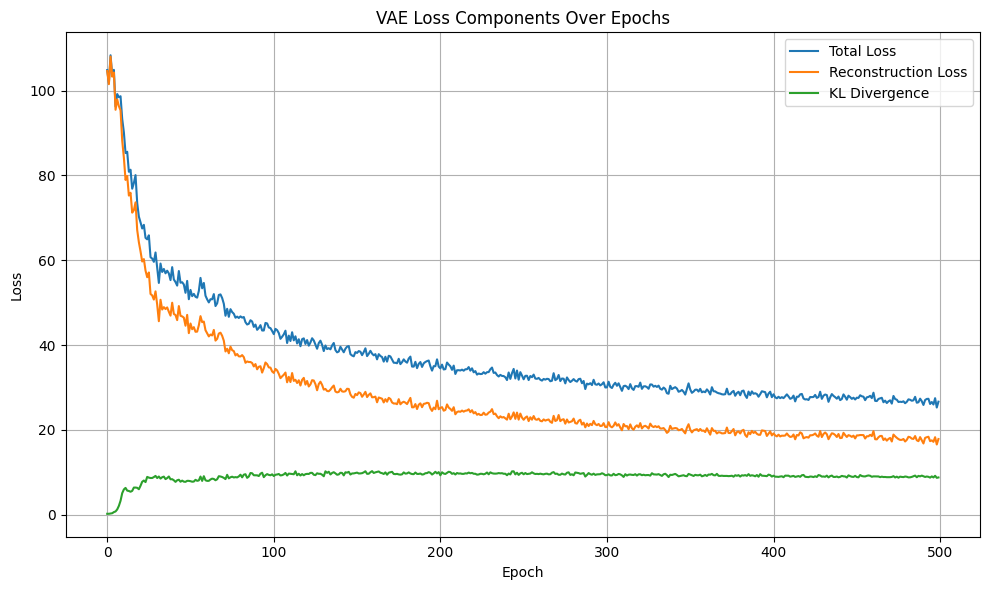

In [6]:
plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

dim of latent mu: (331, 10)


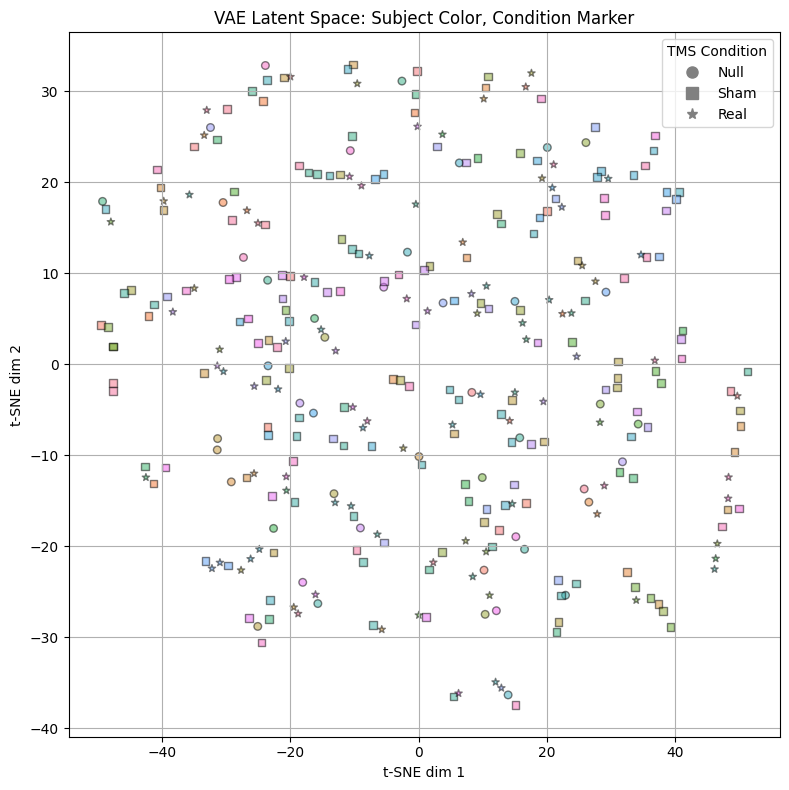

In [7]:
mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=device)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

Paired t-test: t = -3.171, p = 0.0027


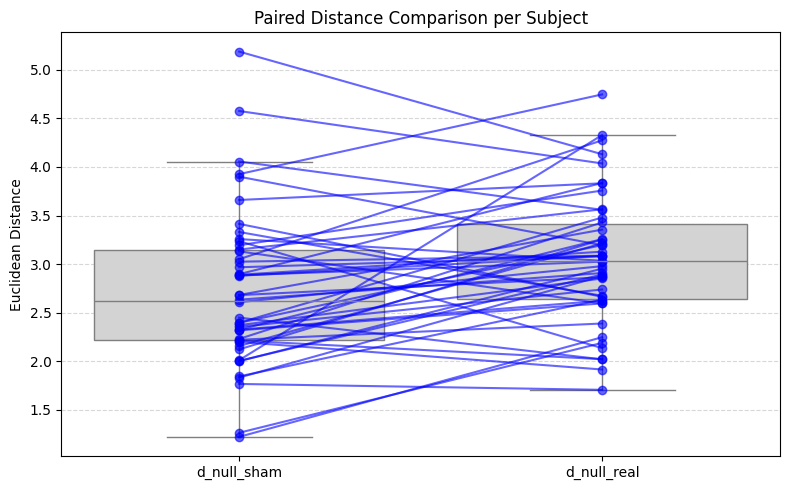

In [8]:
df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)